# Is It Possible to Predict the Occurrence of Violence During a Protest?

In this notebook, we try building different models to predict violence at protests, with the following stakeholders in mind:
* Help people who are going to be part of protests, to decide whether they want to participate or not
* Businesses can decide on whether employees are there or not during the protests; or whether to additionally protect businesses
* Help cities decide on implementation of physical barriers and other passive crowd control methods

We tried 9 different models (including hyperparameter tuning) in the following sequence:
* Use June data to build training set, then apply model to June test set and rest of 2020/2021 dataset
    * Imbalanced dataset results in models that perform not any better than the baseline
* Reduce dataset imbalance by undersampling from the majority, then apply model to June data and rest of 2020/2021 dataset
    * Model performance improves for the June dataset (train and test set) but still does not perform any better than the baseline on the larger dataset (and in fact performs worse)
* Apply PCA to the imbalanced dataset before building models, then apply model to June test set and rest of 2020/2021 dataset

Based on this, we then try a Neural Network.

# Imports

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression # multiple linear regression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier # k-nearest neighbors
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostRegressor, AdaBoostClassifier  # random forest, extratrees
from sklearn.svm import SVC # support vector regressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

## Read in data

In [4]:
df = pd.read_csv('../Data/integrated_protest.csv')

# function to binarize protest status
def yes_violence(row):
    if row == 'Peaceful protest':
        return 0
    else:
        return 1
    
# create binarized violence column based on sub_event_type
df['violence'] = df['sub_event_type'].apply(yes_violence)

# fill 'NA' with 'none'
df['assoc_actor_1'] = df['assoc_actor_1'].fillna('none')

In [5]:
df.shape

(27629, 69)

In [6]:
df.head(2)

,id,date,month,year,city,state,time_precision,event_type,sub_event_type,actor1,assoc_actor_1,type_actor1,actor2,assoc_actor_2,type_actor2,interaction,notes,fatalities,county,latitude,longitude,geo_precision,source_x,source_scale,attendees,tags,curated,source_y,total_articles,totalpop,povertyrate,blackpop,blackpovertyrate,asianpop,asianpoverty,hispanicpop,hispanicpoverty,whitepop,whitepovertyrate,percentbachelor,sqmiles,deaths,deaths_unarmed,deaths_unarmed_black,deaths_armed_black,deaths_black,deaths_protestyear,deaths_protestyear_unarmed,naacpyears,mayorpartisanship,blackmayor,dem,rep,dem_share,pop,hbcu,hbcu2,crime,deathduring,per_ba,per_black,pop_density,collegeenrollpc,mayorrep,unarmed_deaths_pc,deaths_pc,unarmed_deaths_black_pc,deaths_black_pc,violence
0,2020-01-01_cleveland_oh,2020-01-01,1,2020,cleveland,oh,1,Protests,Peaceful protest,Protesters (United States),Health Workers (United States),6,NaN,NaN,0,60,"On 1 January 2020, an unknown number of people associated with the Cleveland Association of Rescue Employees demonstrated at the City Hall in Cleveland (Ohio) to demand mental health benefits. This event was a part of an ongoing strike for new contracts. [size=no report]",0,cuyahoga,41.4822,-81.6697,1,WKYC Studios; Crowd Counting Consortium,Other-Subnational,NaN,NaN,NaN,NaN,NaN,381531.0,35.9,200470.0,43.1,6216.0,25.2,38740.0,40.9,129068.0,23.4,15.344030,77.581,2.0,1.0,1.0,0.0,1.0,5.0,3.0,20.0,D,0.0,156544.0,24049.0,86.68332,45000.0,0.0,0.0,1.0,1.0,15.344030,52.543568,4917.840708,11.794585,0.0,0.02621,0.052420,0.02621,0.026210,0
1,2020-01-01_rochester_ny,2020-01-01,1,2020,rochester,ny,1,Protests,Peaceful protest,Protesters (United States),none,6,NaN,NaN,0,60,"On 1 January 2020, people held a peace march on Lyell Avenue in Rochester (New York) to bring awareness of the crimes in the city and promote peace. [size=no report]",0,monroe,43.1547,-77.6155,1,13WHAM ABC; Democrat and Chronicle; 10NBC,Subnational,NaN,NaN,NaN,NaN,NaN,201739.0,33.8,84385.0,41.5,6444.0,34.9,35683.0,43.8,71731.0,19.5,24.521139,35.809,1.0,0.0,0.0,1.0,1.0,2.0,1.0,4.0,D,1.0,61622.0,11909.0,83.80411,15000.0,0.0,0.0,0.0,1.0,24.521139,41.828799,5633.751292,7.435350,0.0,0.00000,0.049569,0.00000,0.049569,0


### Modeling strategy:
* Use June 2020 data to build model
* Apply model to entire year's protest data

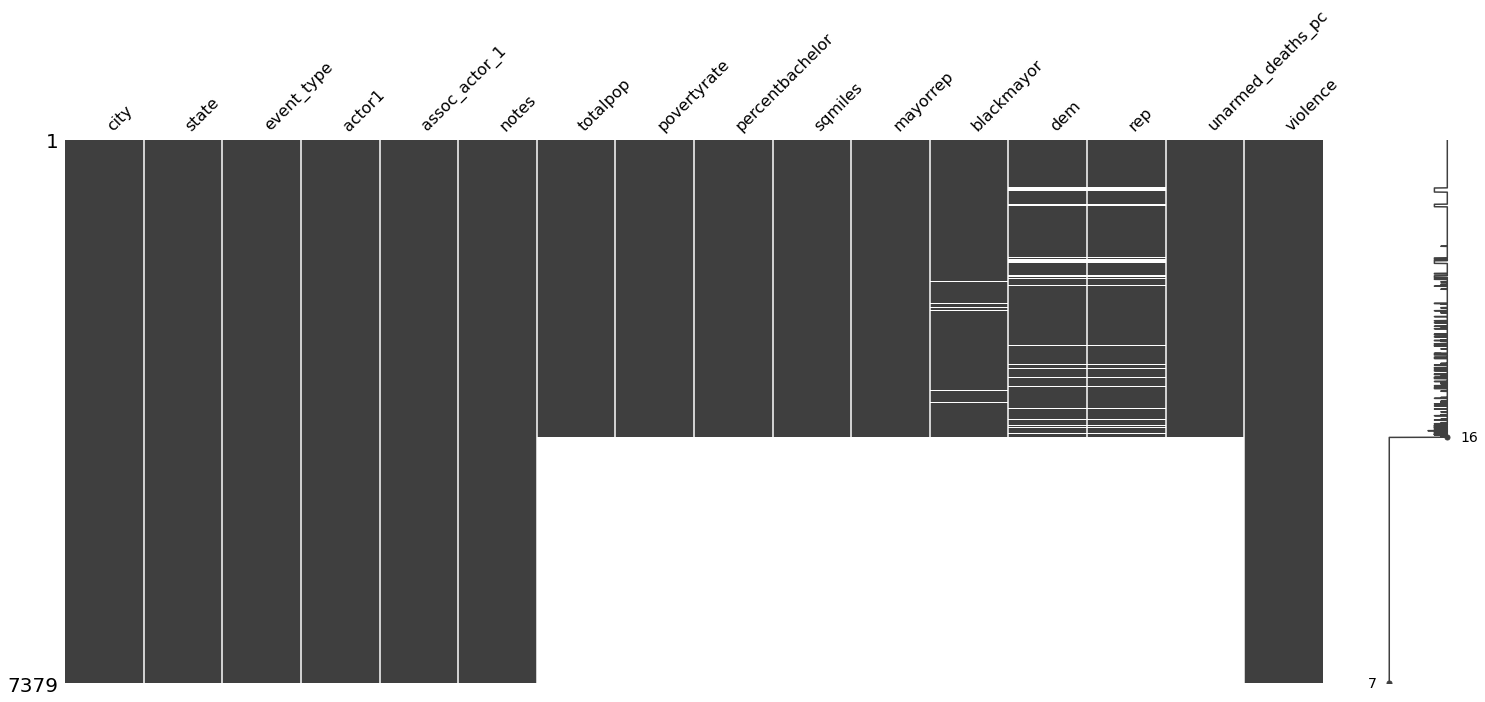

In [9]:
# don't include attendee count because we never know ahead of time how many people are actually going to show up, so can't use that to predict
features = ['city','state','event_type','actor1','assoc_actor_1','notes','totalpop','povertyrate','percentbachelor',
            'sqmiles','mayorrep','blackmayor','dem','rep','unarmed_deaths_pc','violence']

june = df[(df['month']==6)] # 2021 data doesn't have the month of June info yet
df_model = june[features]

msno.matrix(df_model.sort_values(by='totalpop',ascending=False))
plt.show()

### Look at null rows to see what's up

In [10]:
df_model[df_model['totalpop'].isnull()].head(3)

,city,state,event_type,actor1,assoc_actor_1,notes,totalpop,povertyrate,percentbachelor,sqmiles,mayorrep,blackmayor,dem,rep,unarmed_deaths_pc,violence
5427,streator,il,Protests,Protesters (United States),BLM: Black Lives Matter,"On 1 June 2020, an unspecified number of people took part in a protest in Streator (Illinois) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. [size=no report]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5433,nantucket,ma,Protests,Protesters (United States),BLM: Black Lives Matter; Students (United States),"On 1 June 2020, more than 100 people gathered at Tom Nevers Field in Nantucket (Massachusetts) in support of the Black Lives Matter movement and against police brutality and the death of George Floyd. The event was organized by High School students. [size=more than 100]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5434,tisbury,ma,Protests,Protesters (United States),BLM: Black Lives Matter,"On 1 June 2020, over 300 people took part in a protest in Tisbury (Massachusetts) in support of the Black Lives Matter movement, and against police brutality following the police killing of George Floyd on May 25. [size=over 300]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


With time, it should be possible to look up population-related information for these locations. For this work, we drop these rows.

## Prepare for Modeling

In [11]:
df_model = df_model.dropna()
df_model.shape

(3574, 16)

In [12]:
df_model['violence'].value_counts(normalize=True)

0    0.885003
1    0.114997
Name: violence, dtype: float64

In [13]:
df_model['violence'].value_counts()

0    3163
1     411
Name: violence, dtype: int64

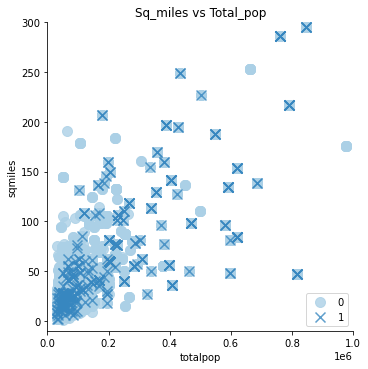

In [14]:
# Let's visualize these events
# plt.scatter(x=df_model['totalpop'],y=df_model['sqmiles'])
sns.lmplot( x="totalpop", y="sqmiles", data=df_model, fit_reg=False, hue='violence', 
           palette='Blues',legend=False, markers=["o", "x"], scatter_kws={"s": 100})
plt.legend(loc='lower right')
plt.xlim(-0.1, 1e6)
plt.ylim(-10,300)
plt.title('Sq_miles vs Total_pop')
plt.show()

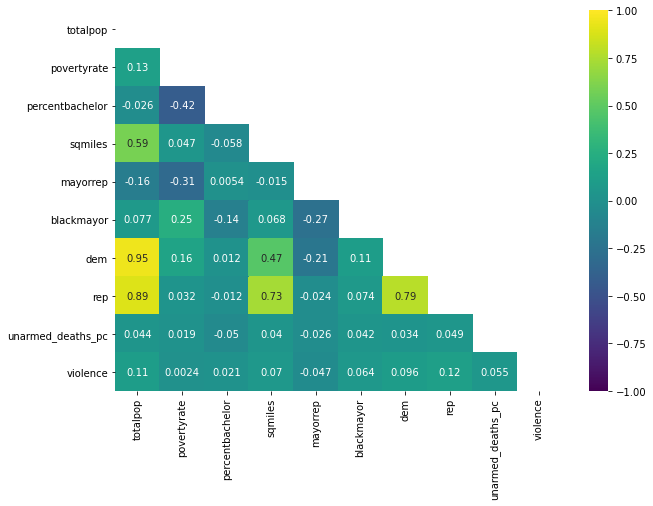

In [16]:
# Visualize using heatmap

plt.figure(figsize=(10,7))
# Get correlation of variables.
corr=df_model.corr()
# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
g=sns.heatmap(corr,annot=True,cmap='viridis',vmin=-1,vmax=1,mask=mask)

* The larger the total population, the higher the number of democrats and republicans (since these will be % of population)
* dem correlation with rep is similar in idea to dem and rep correlation with totalpop
* sqmiles correlation with dem and rep is similar in idea to dem and rep correlation with totalpop
    * because totalpop correlates with sqmiles

### Use a subset of these features for modeling

In [17]:
# df_model['city_state'] = df_model['city']+df_model['state']
model_features = ['totalpop','povertyrate','percentbachelor','sqmiles','mayorrep','blackmayor','dem','rep','unarmed_deaths_pc']

In [18]:
X = df_model[model_features].reset_index()
y = df_model['violence']

In [19]:
# noticed that each entry in 'assoc_actor_1' could possibly consist of many different actors
df_model['assoc_actor_1'].value_counts()

BLM: Black Lives Matter                                                                                                              2235
none                                                                                                                                  292
BLM: Black Lives Matter; Students (United States)                                                                                      87
BLM: Black Lives Matter; Police Forces of the United States (2017-2021)                                                                51
Labour Group (United States)                                                                                                           50
                                                                                                                                     ... 
LGBT (United States); African American Group (United States); Latinx Group (United States); Native American Group (United States)       1
BLM: Black Lives Matter; Police Fo

In [20]:
# split these actors up, and create dummified columns

# join all entries in the 'assoc_actor_1' column into 1, split by ;
assoc_actor_1 = ';'.join(df_model['assoc_actor_1'])

# split this giant string into a list of individual actors
assoc_actor_split = [x.strip() for x in assoc_actor_1.split(';')]

# Create a list of all actors
assoc_actor = []
for i in range(len(assoc_actor_split)):
    if assoc_actor_split[i] not in assoc_actor:
        assoc_actor.append(assoc_actor_split[i])

In [21]:
# create empty df with the columns of interest and the same number of rows as X
temp_df = pd.DataFrame(index = range(df_model.shape[0]), columns = assoc_actor) 

In [22]:
# manual OHE assoc_actor list
# if an item in the assoc_actor list exists in the assoc_actor_1 string, assign that column = 1
for j in range(len(assoc_actor)):
    for ind in range(df_model.shape[0]):
        if assoc_actor[j] in df_model['assoc_actor_1'].iloc[ind]:
            temp_df[assoc_actor[j]].iloc[ind]=1
        else:
            temp_df[assoc_actor[j]].iloc[ind]=0

In [23]:
temp_df.head(3)

,none,BLM: Black Lives Matter,Civilians (United States),Journalists (United States),NAACP: National Association for the Advancement of Colored People,African American Group (United States),Christian Group (United States),Government of the United States (2017-2021),Police Forces of the United States (2017-2021),White Nationalists (United States),Students (United States),Sole Perpetrator (United States),Native American Group (United States),Catholic Christian Group (United States),Health Workers (United States),Unidentified Communal Militia (United States),Interfaith Group (United States),Jewish Group (United States),Muslim Group (United States),North State Militia,Boogaloo Boys,Protestant Christian Group (United States),Latinx Group (United States),LGBT (United States),Teachers (United States),Lawyers (United States),Pro-Police Group (United States),Women (United States),Labour Group (United States),Poor People's Campaign,SEIU: Service Employees International Union,DSA: Democratic Socialists of America,CAIR: Council on American-Islamic Relations,MDA: Moms Demand Action for Gun Sense in America,Indivisible Movement,Philadelphia Housing Action,Texas Freedom Militia,Military Forces of the United States (2017-2021),Open Carry Texas,LULAC: League of United Latin American Citizens,DEM: Democratic Party,Evangelical Christian Group (United States),LFM: Light Foot Militia,NLM: Native Lives Matter,Citizen Action,PSL: Party for Socialism and Liberation,Back the Blue,CCBP: Chesapeake Coalition of Black Pastors,NIOT: Not In Our Town,Cancel the Rents Movement,Filipino Group (United States),UFCW: United Food and Commercial Workers,IBT: International Brotherhood of Teamsters,Arab Ethnic Group (United States),Blue Lives Matter,Free Ohio Now,SAP: Socialist Alternative Party,Antifa (United States),Farmers (United States),Migrants (International),UPTE: University Professional and Technical Employees,DREAMers Movement (United States),Unitarian Universalist Group (United States),TFPSA: TFP Student Action,SM: Sunrise Movement,Former Military Forces of the United States (2017-2021),Former Police Forces of the United States (2017-2021),APWU: American Postal Workers Union,Judges (United States),"IATSE: International Alliance of Theatrical Stage Employees, Moving Picture Technicians, Artists and Allied Crafts of the United States",UFW: United Farm Workers of America,Abolish ICE,RUP: Raza Unida Party,Los Brown Berets,Red Nation,Three Percenters (III%),Asian American Group (United States)
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# concatenate with X
X = pd.concat([X, temp_df], axis=1)
X.drop(columns = 'index', inplace=True)
X.head()

,totalpop,povertyrate,percentbachelor,sqmiles,mayorrep,blackmayor,dem,rep,unarmed_deaths_pc,none,BLM: Black Lives Matter,Civilians (United States),Journalists (United States),NAACP: National Association for the Advancement of Colored People,African American Group (United States),Christian Group (United States),Government of the United States (2017-2021),Police Forces of the United States (2017-2021),White Nationalists (United States),Students (United States),Sole Perpetrator (United States),Native American Group (United States),Catholic Christian Group (United States),Health Workers (United States),Unidentified Communal Militia (United States),Interfaith Group (United States),Jewish Group (United States),Muslim Group (United States),North State Militia,Boogaloo Boys,Protestant Christian Group (United States),Latinx Group (United States),LGBT (United States),Teachers (United States),Lawyers (United States),Pro-Police Group (United States),Women (United States),Labour Group (United States),Poor People's Campaign,SEIU: Service Employees International Union,DSA: Democratic Socialists of America,CAIR: Council on American-Islamic Relations,MDA: Moms Demand Action for Gun Sense in America,Indivisible Movement,Philadelphia Housing Action,Texas Freedom Militia,Military Forces of the United States (2017-2021),Open Carry Texas,LULAC: League of United Latin American Citizens,DEM: Democratic Party,Evangelical Christian Group (United States),LFM: Light Foot Militia,NLM: Native Lives Matter,Citizen Action,PSL: Party for Socialism and Liberation,Back the Blue,CCBP: Chesapeake Coalition of Black Pastors,NIOT: Not In Our Town,Cancel the Rents Movement,Filipino Group (United States),UFCW: United Food and Commercial Workers,IBT: International Brotherhood of Teamsters,Arab Ethnic Group (United States),Blue Lives Matter,Free Ohio Now,SAP: Socialist Alternative Party,Antifa (United States),Farmers (United States),Migrants (International),UPTE: University Professional and Technical Employees,DREAMers Movement (United States),Unitarian Universalist Group (United States),TFPSA: TFP Student Action,SM: Sunrise Movement,Former Military Forces of the United States (2017-2021),Former Police Forces of the United States (2017-2021),APWU: American Postal Workers Union,Judges (United States),"IATSE: International Alliance of Theatrical Stage Employees, Moving Picture Technicians, Artists and Allied Crafts of the United States",UFW: United Farm Workers of America,Abolish ICE,RUP: Raza Unida Party,Los Brown Berets,Red Nation,Three Percenters (III%),Asian American Group (United States)
0,44724.0,15.9,24.004941,15.544,1.0,0.0,3560.0,4394.0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3793097.0,22.4,31.647981,468.642,0.0,0.0,861950.0,253916.0,0.010545,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3793097.0,22.4,31.647981,468.642,0.0,0.0,861950.0,253916.0,0.010545,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3793097.0,22.4,31.647981,468.642,0.0,0.0,861950.0,253916.0,0.010545,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3793097.0,22.4,31.647981,468.642,0.0,0.0,861950.0,253916.0,0.010545,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Apply Supervised Classification Models

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [27]:
models = [('lr', LogisticRegression()),
          ('knn', KNeighborsClassifier()),
          ('cart', DecisionTreeClassifier()),
          ('bag', BaggingClassifier()),
          ('rf', RandomForestClassifier()),
          ('ada', AdaBoostClassifier()),
          ('svc', SVC())
         ]

ss_params = {'ss__with_mean':[True, False], 'ss__with_std':[True, False]}

params = [{'lr__solver': ['liblinear'], 'lr__C': [2, 5, 10], 'lr__penalty': ['l1','l2'], 'lr__max_iter': [100, 500, 1000]}, # logreg
          {'knn__n_neighbors':[1, 3, 5, 7, 11, 23], 'knn__weights':['uniform','distance']}, # knn
         {'cart__max_depth': [2, 3, 5, 7], 'cart__min_samples_split': [5, 7, 10, 15, 20], 'cart__min_samples_leaf': [2, 3, 4, 5, 6], 
          'cart__ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10], 'cart__random_state': [42]}, # decision tree
         {'bag__n_estimators': [10, 100, 200], 'bag__random_state': [42], 'bag__n_jobs': [4]}, # bagging
         {'rf__max_depth': [5], 'rf__random_state': [42]}, # random forest
         {'ada__n_estimators': [10, 100, 200], 'ada__random_state': [42]}, # adaboost
         {'svc__C': np.linspace(0, 5, 10), 'svc__kernel':['rbf','polynomial'], 'svc__degree':list(range(4)), 'svc__random_state':[42]}] # SVC

In [28]:
pipelines = []
pipe_params = []
pipe_gs = []

for ind in range(len(models)):
    pipelines.append(Pipeline([('ss', StandardScaler()),
                             models[ind]]))
    
    res = ss_params.copy()
    res.update(params[ind])
    pipe_params.append(res)
    
    pipe_gs.append(GridSearchCV(Pipeline([('ss', StandardScaler()), models[ind]]),
                  res,
                  cv=5,
                  verbose=1,
                  n_jobs=4))

In [29]:
pipelines

[Pipeline(steps=[('ss', StandardScaler()), ('lr', LogisticRegression())]),
 Pipeline(steps=[('ss', StandardScaler()), ('knn', KNeighborsClassifier())]),
 Pipeline(steps=[('ss', StandardScaler()), ('cart', DecisionTreeClassifier())]),
 Pipeline(steps=[('ss', StandardScaler()), ('bag', BaggingClassifier())]),
 Pipeline(steps=[('ss', StandardScaler()), ('rf', RandomForestClassifier())]),
 Pipeline(steps=[('ss', StandardScaler()), ('ada', AdaBoostClassifier())]),
 Pipeline(steps=[('ss', StandardScaler()), ('svc', SVC())])]

In [30]:
pipe_params

[{'ss__with_mean': [True, False],
  'ss__with_std': [True, False],
  'lr__solver': ['liblinear'],
  'lr__C': [2, 5, 10],
  'lr__penalty': ['l1', 'l2'],
  'lr__max_iter': [100, 500, 1000]},
 {'ss__with_mean': [True, False],
  'ss__with_std': [True, False],
  'knn__n_neighbors': [1, 3, 5, 7, 11, 23],
  'knn__weights': ['uniform', 'distance']},
 {'ss__with_mean': [True, False],
  'ss__with_std': [True, False],
  'cart__max_depth': [2, 3, 5, 7],
  'cart__min_samples_split': [5, 7, 10, 15, 20],
  'cart__min_samples_leaf': [2, 3, 4, 5, 6],
  'cart__ccp_alpha': [0, 0.001, 0.01, 0.1, 1, 10],
  'cart__random_state': [42]},
 {'ss__with_mean': [True, False],
  'ss__with_std': [True, False],
  'bag__n_estimators': [10, 100, 200],
  'bag__random_state': [42],
  'bag__n_jobs': [4]},
 {'ss__with_mean': [True, False],
  'ss__with_std': [True, False],
  'rf__max_depth': [5],
  'rf__random_state': [42]},
 {'ss__with_mean': [True, False],
  'ss__with_std': [True, False],
  'ada__n_estimators': [10, 100, 

In [31]:
pipe_gs

[GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('ss', StandardScaler()),
                                        ('lr', LogisticRegression())]),
              n_jobs=4,
              param_grid={'lr__C': [2, 5, 10], 'lr__max_iter': [100, 500, 1000],
                          'lr__penalty': ['l1', 'l2'],
                          'lr__solver': ['liblinear'],
                          'ss__with_mean': [True, False],
                          'ss__with_std': [True, False]},
              verbose=1),
 GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('ss', StandardScaler()),
                                        ('knn', KNeighborsClassifier())]),
              n_jobs=4,
              param_grid={'knn__n_neighbors': [1, 3, 5, 7, 11, 23],
                          'knn__weights': ['uniform', 'distance'],
                          'ss__with_mean': [True, False],
                          'ss__with_std': [True, False]},
              verbose=1),
 GridSearchCV(cv=5,
   

In [39]:
evaluations1 = []

for gs in pipe_gs:
    gs.fit(X_train, y_train)
    
    evaluations2.append({
        'pipe': [step[0] for step in gs.estimator.steps],
        'train score': gs.score(X_train, y_train),
        'cross val': cross_val_score(gs.estimator, X_train, y_train, cv=5).mean(),
        'test score': gs.score(X_test, y_test),
        'f1-score (train)': f1_score(y_true = y_train, y_pred = gs.predict(X_train)),
        'f1-score (test)': f1_score(y_true = y_test, y_pred = gs.predict(X_test))
    })
    
evaluations1_df = pd.DataFrame(evaluations2)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   19.6s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:   17.0s finished


Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   20.9s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:   41.7s
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 4876 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 6376 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 8076 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 9976 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 12000 out of 12000 | elapsed:  5.7min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   30.5s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    4.3s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   19.6s finished


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 240 tasks      | elapsed:   25.3s
[Parallel(n_jobs=4)]: Done 540 tasks      | elapsed:   54.5s
[Parallel(n_jobs=4)]: Done 1160 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:  2.5min finished


,pipe,train score,cross val,test score,f1-score (train),f1-score (test)
0,"[ss, lr]",0.902413,0.899964,0.896503,0.279070,0.212766
1,"[ss, knn]",0.898216,0.891567,0.892308,0.302158,0.222222
2,"[ss, lr]",0.902413,0.899964,0.896503,0.279070,0.212766
3,"[ss, knn]",0.898216,0.891567,0.892308,0.302158,0.222222
4,"[ss, cart]",0.898916,0.871973,0.895105,0.216802,0.157303
5,"[ss, bag]",0.932844,0.878621,0.893706,0.632184,0.377049
6,"[ss, rf]",0.897517,0.887015,0.895105,0.197260,0.157303
7,"[ss, ada]",0.898216,0.894714,0.895105,0.219839,0.175824
8,"[ss, svc]",0.903463,0.899964,0.895105,0.277487,0.157303


In [40]:
evaluations1_df

,pipe,train score,cross val,test score,f1-score (train),f1-score (test)
0,"[ss, lr]",0.902413,0.899964,0.896503,0.279070,0.212766
1,"[ss, knn]",0.898216,0.891567,0.892308,0.302158,0.222222
2,"[ss, lr]",0.902413,0.899964,0.896503,0.279070,0.212766
3,"[ss, knn]",0.898216,0.891567,0.892308,0.302158,0.222222
4,"[ss, cart]",0.898916,0.871973,0.895105,0.216802,0.157303
5,"[ss, bag]",0.932844,0.878621,0.893706,0.632184,0.377049
6,"[ss, rf]",0.897517,0.887015,0.895105,0.197260,0.157303
7,"[ss, ada]",0.898216,0.894714,0.895105,0.219839,0.175824
8,"[ss, svc]",0.903463,0.899964,0.895105,0.277487,0.157303


In [41]:
df_model['violence'].value_counts(normalize=True)

0    0.885003
1    0.114997
Name: violence, dtype: float64

The Bagging Classifier is the best performer of all the models evaluated (comparing test f1-score), though all of them perform only marginally better than the baseline model.

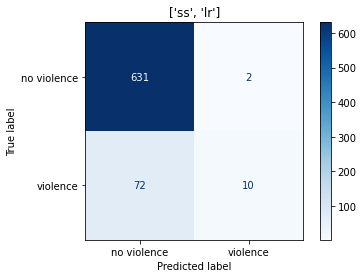

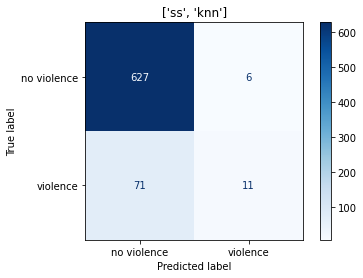

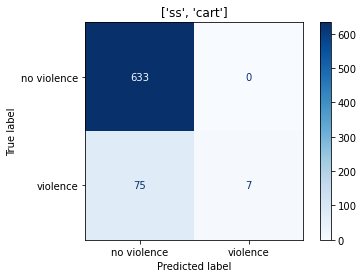

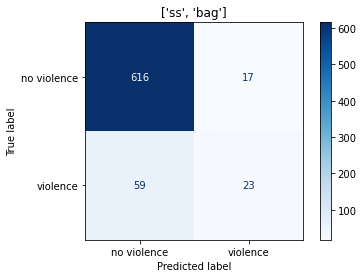

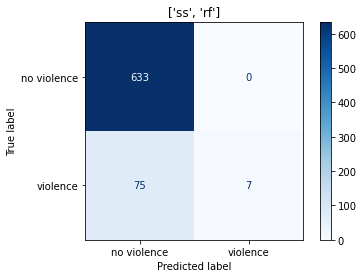

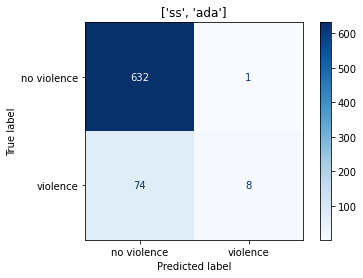

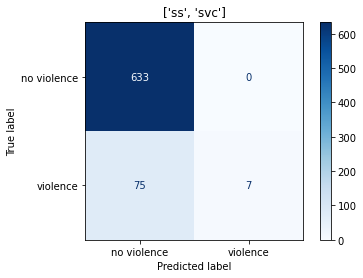

In [42]:
for gs in pipe_gs:
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['no violence','violence']);
    plt.title([step[0] for step in gs.estimator.steps])

I think we'd want to minimize the number of incorrectly predicted peaceful protests, as protestors do not want to encounter violence under any circumstances. Therefore the best model is still the Bagging Classifier. But still, the protests that are incorrectly predicted as peaceful, that are actually violent, is still high.

# Let's assess the performance of this model on the rest of the data, not from June

In [44]:
not_june = df[df['month']!=6].copy()
not_june['violence'] = not_june['sub_event_type'].apply(yes_violence)
not_june = not_june[features]
not_june.shape

(20250, 16)

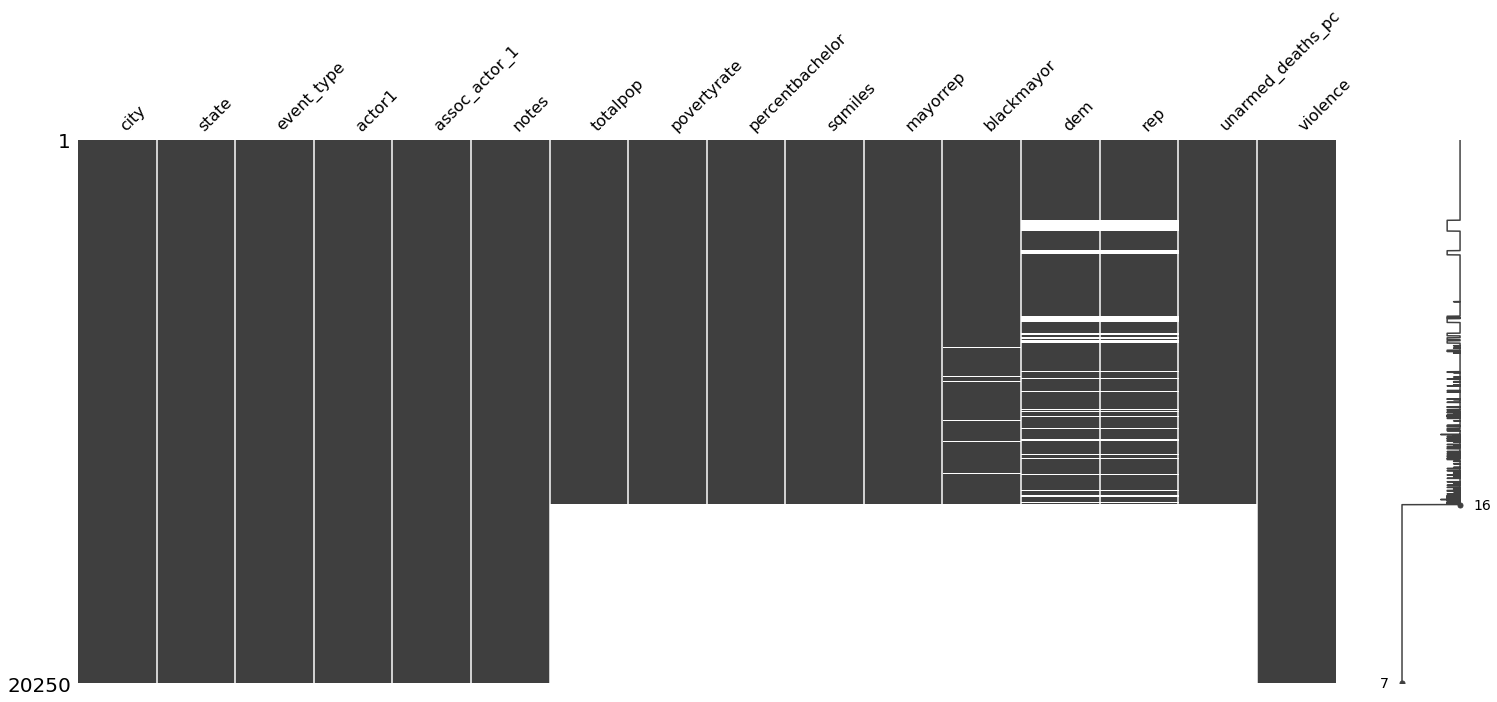

In [45]:
msno.matrix(not_june.sort_values(by='totalpop',ascending=False))
plt.show()

In [46]:
not_june = not_june.dropna()
not_june.shape

(11829, 16)

In [47]:
not_june['violence'].value_counts(normalize=True)

0    0.866853
1    0.133147
Name: violence, dtype: float64

In [48]:
Xxjune = not_june[model_features].reset_index()
yxjune = not_june['violence']

In [49]:
# create empty df with the columns of interest and the same number of rows as X
temp_df = pd.DataFrame(index = range(not_june.shape[0]), columns = assoc_actor) 

In [50]:
# if an item in the assoc_actor list exists in the assoc_actor_1 string, assign that column = 1
for j in range(len(assoc_actor)):
    for ind in range(not_june.shape[0]):
        if assoc_actor[j] in not_june['assoc_actor_1'].iloc[ind]:
            temp_df[assoc_actor[j]].iloc[ind]=1
        else:
            temp_df[assoc_actor[j]].iloc[ind]=0

In [51]:
Xxjune = pd.concat([Xxjune, temp_df], axis=1)
Xxjune.drop(columns = 'index', inplace=True)
Xxjune.head()

,totalpop,povertyrate,percentbachelor,sqmiles,mayorrep,blackmayor,dem,rep,unarmed_deaths_pc,none,BLM: Black Lives Matter,Civilians (United States),Journalists (United States),NAACP: National Association for the Advancement of Colored People,African American Group (United States),Christian Group (United States),Government of the United States (2017-2021),Police Forces of the United States (2017-2021),White Nationalists (United States),Students (United States),Sole Perpetrator (United States),Native American Group (United States),Catholic Christian Group (United States),Health Workers (United States),Unidentified Communal Militia (United States),Interfaith Group (United States),Jewish Group (United States),Muslim Group (United States),North State Militia,Boogaloo Boys,Protestant Christian Group (United States),Latinx Group (United States),LGBT (United States),Teachers (United States),Lawyers (United States),Pro-Police Group (United States),Women (United States),Labour Group (United States),Poor People's Campaign,SEIU: Service Employees International Union,DSA: Democratic Socialists of America,CAIR: Council on American-Islamic Relations,MDA: Moms Demand Action for Gun Sense in America,Indivisible Movement,Philadelphia Housing Action,Texas Freedom Militia,Military Forces of the United States (2017-2021),Open Carry Texas,LULAC: League of United Latin American Citizens,DEM: Democratic Party,Evangelical Christian Group (United States),LFM: Light Foot Militia,NLM: Native Lives Matter,Citizen Action,PSL: Party for Socialism and Liberation,Back the Blue,CCBP: Chesapeake Coalition of Black Pastors,NIOT: Not In Our Town,Cancel the Rents Movement,Filipino Group (United States),UFCW: United Food and Commercial Workers,IBT: International Brotherhood of Teamsters,Arab Ethnic Group (United States),Blue Lives Matter,Free Ohio Now,SAP: Socialist Alternative Party,Antifa (United States),Farmers (United States),Migrants (International),UPTE: University Professional and Technical Employees,DREAMers Movement (United States),Unitarian Universalist Group (United States),TFPSA: TFP Student Action,SM: Sunrise Movement,Former Military Forces of the United States (2017-2021),Former Police Forces of the United States (2017-2021),APWU: American Postal Workers Union,Judges (United States),"IATSE: International Alliance of Theatrical Stage Employees, Moving Picture Technicians, Artists and Allied Crafts of the United States",UFW: United Farm Workers of America,Abolish ICE,RUP: Raza Unida Party,Los Brown Berets,Red Nation,Three Percenters (III%),Asian American Group (United States)
0,381531.0,35.9,15.344030,77.581,0.0,0.0,156544.0,24049.0,0.026210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,201739.0,33.8,24.521139,35.809,0.0,1.0,61622.0,11909.0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,396963.0,21.0,38.786488,55.856,0.0,0.0,150563.0,11615.0,0.050383,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1473375.0,23.2,26.665009,515.315,0.0,0.0,217262.0,208490.0,0.033936,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,588853.0,18.2,28.818236,606.422,1.0,0.0,76994.0,111759.0,0.016982,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
# create a new list of fitted pipelines, to place metrics

evaluations_rest = []
for gs in pipe_gs:
    evaluations_rest.append({
        'pipe': [step[0] for step in gs.estimator.steps],
        'test score': gs.score(Xxjune, yxjune),
        'f1-score (test)': f1_score(y_true = yxjune, y_pred = gs.predict(Xxjune))
    })

# for pipe in pipelines:
#     evaluations_rest.append({
#         'pipe': [step[0] for step in pipe.steps],
#         'test score': pipe.score(Xxjune, yxjune),
#         'rmse (test)': mean_squared_error(y_true = yxjune, y_pred = pipe.predict(Xxjune),
#                                           squared = False)
#     })

# for gs in pipe_gs:
#     gs.fit(X_train, y_train)
    
#     evaluations2.append({
#         'pipe': [step[0] for step in gs.estimator.steps],
#         'train score': gs.score(X_train, y_train),
#         'cross val': cross_val_score(gs.estimator, X_train, y_train, cv=5).mean(),
#         'test score': gs.score(X_test, y_test),
#         'f1-score (train)': f1_score(y_true = y_train, y_pred = gs.predict(X_train)),
#         'f1-score (test)': f1_score(y_true = y_test, y_pred = gs.predict(X_test))
#     })
    
evaluations_rest_df = pd.DataFrame(evaluations_rest)

In [53]:
evaluations_rest_df

,pipe,test score,f1-score (test)
0,"[ss, lr]",0.867783,0.150923
1,"[ss, knn]",0.866430,0.127072
2,"[ss, cart]",0.874546,0.109244
3,"[ss, bag]",0.839293,0.231919
4,"[ss, rf]",0.873700,0.097826
5,"[ss, ada]",0.867106,0.117845
6,"[ss, svc]",0.871333,0.126292


In [54]:
1-(sum(yxjune)/yxjune.shape[0])

0.8668526502662948

These models don't work very well across the whole dataset either, compared to the baseline model.

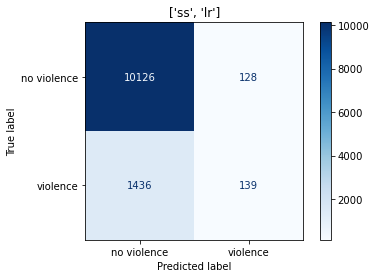

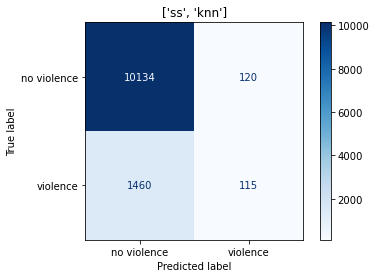

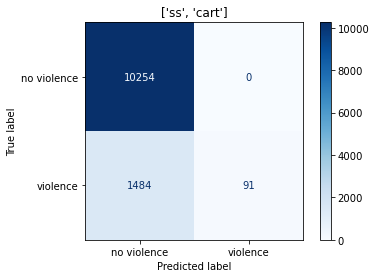

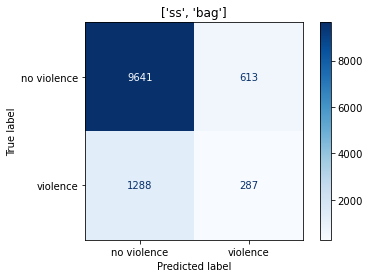

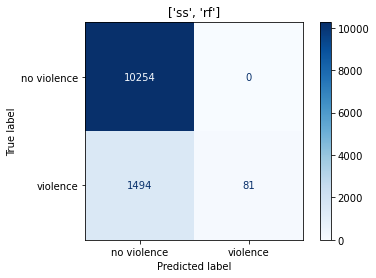

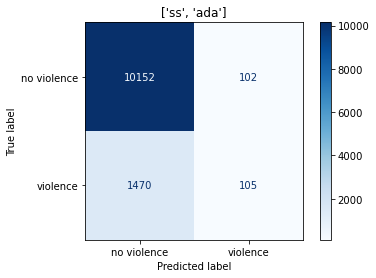

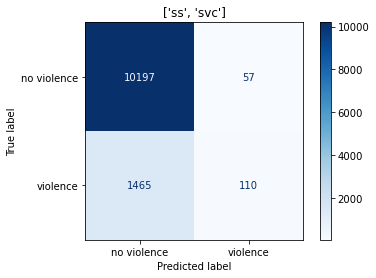

In [55]:
# for pipe in pipelines:
#     plot_confusion_matrix(pipe, Xxjune, yxjune, cmap='Blues', 
#                       values_format='d', display_labels=['no violence','violence']);
#     plt.title([step[0] for step in pipe.steps])

# plot confusion matrix
for gs in pipe_gs:
    plot_confusion_matrix(gs, Xxjune, yxjune, cmap='Blues', 
                      values_format='d', display_labels=['no violence','violence']);
    plt.title([step[0] for step in gs.estimator.steps])

None of these are great. Try to reduce the imbalance in the dataset.

## Reduce dataset imbalance then apply classification models

In [56]:
# rebuild dataset
rebuild = X.copy()
targety = y.copy().reset_index(drop=True)
rebuild['target'] = targety
rebuild.head()

,totalpop,povertyrate,percentbachelor,sqmiles,mayorrep,blackmayor,dem,rep,unarmed_deaths_pc,none,BLM: Black Lives Matter,Civilians (United States),Journalists (United States),NAACP: National Association for the Advancement of Colored People,African American Group (United States),Christian Group (United States),Government of the United States (2017-2021),Police Forces of the United States (2017-2021),White Nationalists (United States),Students (United States),Sole Perpetrator (United States),Native American Group (United States),Catholic Christian Group (United States),Health Workers (United States),Unidentified Communal Militia (United States),Interfaith Group (United States),Jewish Group (United States),Muslim Group (United States),North State Militia,Boogaloo Boys,Protestant Christian Group (United States),Latinx Group (United States),LGBT (United States),Teachers (United States),Lawyers (United States),Pro-Police Group (United States),Women (United States),Labour Group (United States),Poor People's Campaign,SEIU: Service Employees International Union,DSA: Democratic Socialists of America,CAIR: Council on American-Islamic Relations,MDA: Moms Demand Action for Gun Sense in America,Indivisible Movement,Philadelphia Housing Action,Texas Freedom Militia,Military Forces of the United States (2017-2021),Open Carry Texas,LULAC: League of United Latin American Citizens,DEM: Democratic Party,Evangelical Christian Group (United States),LFM: Light Foot Militia,NLM: Native Lives Matter,Citizen Action,PSL: Party for Socialism and Liberation,Back the Blue,CCBP: Chesapeake Coalition of Black Pastors,NIOT: Not In Our Town,Cancel the Rents Movement,Filipino Group (United States),UFCW: United Food and Commercial Workers,IBT: International Brotherhood of Teamsters,Arab Ethnic Group (United States),Blue Lives Matter,Free Ohio Now,SAP: Socialist Alternative Party,Antifa (United States),Farmers (United States),Migrants (International),UPTE: University Professional and Technical Employees,DREAMers Movement (United States),Unitarian Universalist Group (United States),TFPSA: TFP Student Action,SM: Sunrise Movement,Former Military Forces of the United States (2017-2021),Former Police Forces of the United States (2017-2021),APWU: American Postal Workers Union,Judges (United States),"IATSE: International Alliance of Theatrical Stage Employees, Moving Picture Technicians, Artists and Allied Crafts of the United States",UFW: United Farm Workers of America,Abolish ICE,RUP: Raza Unida Party,Los Brown Berets,Red Nation,Three Percenters (III%),Asian American Group (United States),target
0,44724.0,15.9,24.004941,15.544,1.0,0.0,3560.0,4394.0,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,3793097.0,22.4,31.647981,468.642,0.0,0.0,861950.0,253916.0,0.010545,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,3793097.0,22.4,31.647981,468.642,0.0,0.0,861950.0,253916.0,0.010545,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3793097.0,22.4,31.647981,468.642,0.0,0.0,861950.0,253916.0,0.010545,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3793097.0,22.4,31.647981,468.642,0.0,0.0,861950.0,253916.0,0.010545,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [57]:
# reduce imbalance

# peaceful protest dataset
peaceful = rebuild[rebuild['target']==0]

# sample from peaceful protest dataset
sub_peaceful = peaceful.sample(frac=0.20)

# not_peaceful dataset
not_peaceful = rebuild[rebuild['target']==1]

# recombine datasets
rebalance = pd.concat([sub_peaceful, not_peaceful])
rebalance['target'].value_counts(normalize=True)

0    0.606322
1    0.393678
Name: target, dtype: float64

In [58]:
# split into predictors and target

Xb = rebalance.drop(columns='target')
yb = rebalance['target']

In [59]:
Xb.shape, yb.shape

((1044, 86), (1044,))

In [60]:
# train/test split
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=42, stratify=yb)

In [61]:
# run models and collect scores in a dataframe
evaluations3 = []

for gs in pipe_gs:
    gs.fit(Xb_train, yb_train)
    
    evaluations3.append({
        'pipe': [step[0] for step in gs.estimator.steps],
        'train score': gs.score(Xb_train, yb_train),
        'cross val': cross_val_score(gs.estimator, Xb_train, yb_train, cv=5).mean(),
        'test score': gs.score(Xb_test, yb_test),
        'f1-score (train)': f1_score(y_true = yb_train, y_pred = gs.predict(Xb_train)),
        'f1-score (test)': f1_score(y_true = yb_test, y_pred = gs.predict(Xb_test))
    })
    
evaluations3_df = pd.DataFrame(evaluations3)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  80 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    5.4s finished


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:    2.8s finished


Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 3400 tasks      | elapsed:   31.5s
[Parallel(n_jobs=4)]: Done 6200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 9800 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 12000 out of 12000 | elapsed:  2.7min finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   19.0s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.8s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   11.4s finished


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done 1593 out of 1600 | elapsed:   39.9s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:   39.9s finished


In [62]:
evaluations3_df

,pipe,train score,cross val,test score,f1-score (train),f1-score (test)
0,"[ss, lr]",0.723353,0.700599,0.712919,0.564972,0.516129
1,"[ss, knn]",0.895808,0.688623,0.741627,0.863850,0.670732
2,"[ss, cart]",0.701796,0.656287,0.703349,0.480167,0.465517
3,"[ss, bag]",0.895808,0.688623,0.732057,0.866359,0.650000
4,"[ss, rf]",0.748503,0.702994,0.732057,0.564315,0.533333
5,"[ss, ada]",0.710180,0.682635,0.717703,0.504098,0.512397
6,"[ss, svc]",0.749701,0.706587,0.741627,0.616514,0.590909


The baseline model is 60.6% accurate. From our optimized models, even though it is still very much overfit, the K-Nearest Classifier model resulted in the best test score (74.2%) and test f1-score (0.67). This is much better than the original models. Let's look at the confusion matrix to verify.

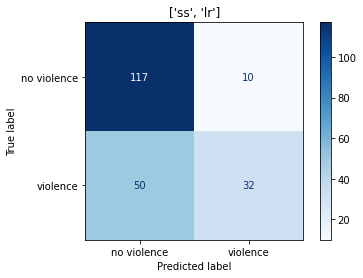

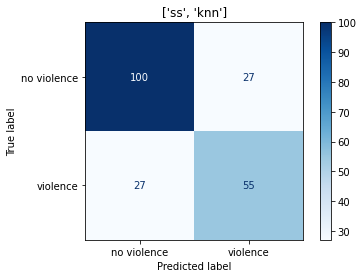

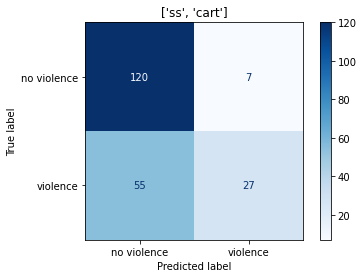

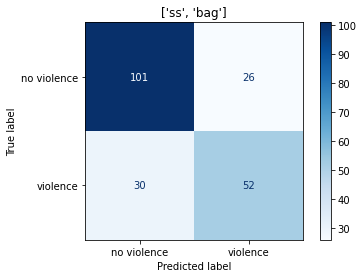

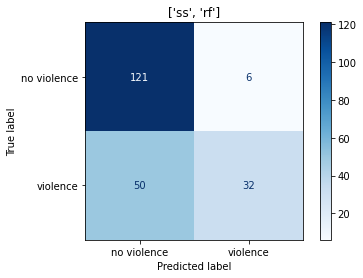

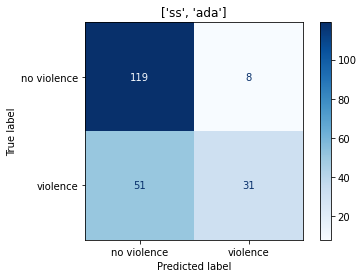

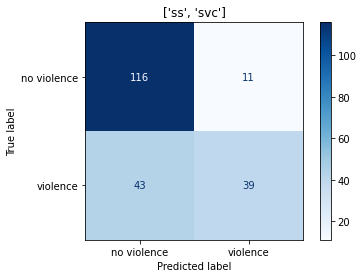

In [63]:
# plot confusion matrix
for gs in pipe_gs:
    plot_confusion_matrix(gs, Xb_test, yb_test, cmap='Blues', 
                      values_format='d', display_labels=['no violence','violence']);
    plt.title([step[0] for step in gs.estimator.steps])

In [64]:
# Apply these models to the rest of the dataset (excluding all of June)

evaluations3_rest = []
for gs in pipe_gs:
    evaluations3_rest.append({
        'pipe': [step[0] for step in gs.estimator.steps],
        'test score': gs.score(Xxjune, yxjune),
        'f1-score (test)': f1_score(y_true = yxjune, y_pred = gs.predict(Xxjune))
    })
    
evaluations3_rest_df = pd.DataFrame(evaluations3_rest)

In [65]:
evaluations3_rest_df

,pipe,test score,f1-score (test)
0,"[ss, lr]",0.643926,0.304262
1,"[ss, knn]",0.676980,0.321917
2,"[ss, cart]",0.672415,0.301676
3,"[ss, bag]",0.641221,0.301514
4,"[ss, rf]",0.725590,0.306410
5,"[ss, ada]",0.685011,0.290015
6,"[ss, svc]",0.647646,0.315375


In [66]:
yxjune.value_counts(normalize=True)

0    0.866853
1    0.133147
Name: violence, dtype: float64

When applied to the rest of the dataset, the test scores are now lower than the baseline model, and perform worse than the previous set of models. Which ultimately means that the model is not great for application to the larger dataset. Looks like these models work best on the dataset that we trained it on, and the most-alike dataset (events from the month of June).

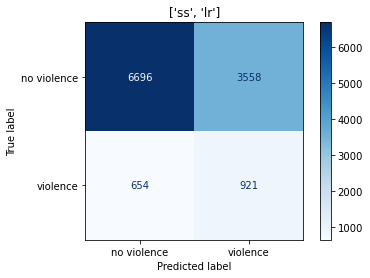

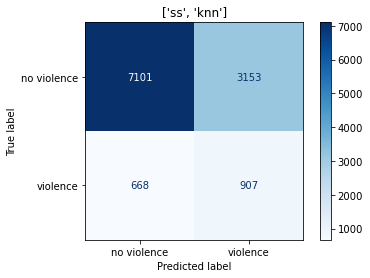

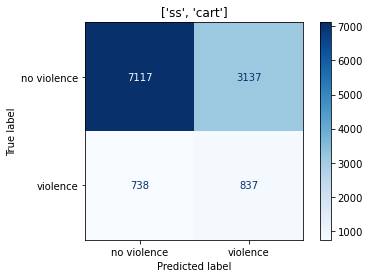

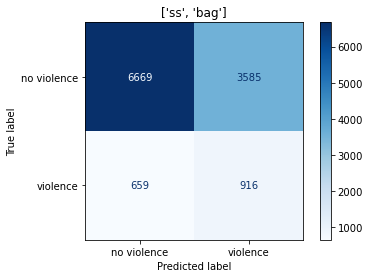

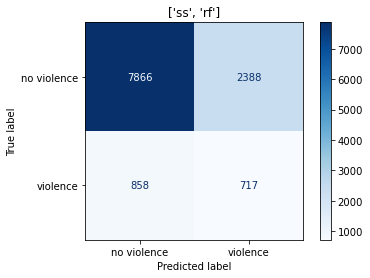

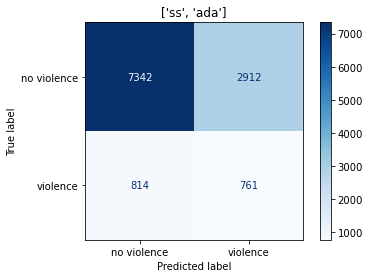

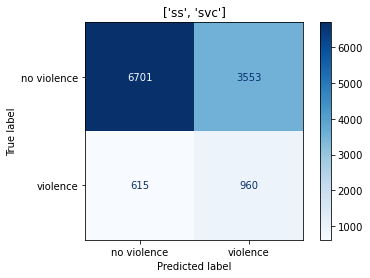

In [68]:
# plot confusion matrix
for gs in pipe_gs:
    plot_confusion_matrix(gs, Xxjune, yxjune, cmap='Blues', 
                      values_format='d', display_labels=['no violence','violence']);
    plt.title([step[0] for step in gs.estimator.steps])

Looks like the errors are mostly from mispredicting protests as violent, which ultimately are actually peaceful. Let's try PCA.

## Apply PCA to rebalanced data before modeling

In [71]:
# data for modeling (rebalanced June dataset)
# Xb_train, Xb_test, yb_train, yb_test

# data for testing (whole dataset exxcept for June)
# Xxjune, yxjune

In [86]:
# split up numerical features from categorical features
num_cols = ['totalpop', 'povertyrate', 'percentbachelor', 'sqmiles', 'dem', 'rep', 'unarmed_deaths_pc']

# numerical X
Xb_train_num = Xb_train[num_cols].reset_index(drop=True)
Xb_test_num = Xb_test[num_cols].reset_index(drop=True)

# categorical X
Xb_train_cat = Xb_train.drop(columns=num_cols).reset_index(drop=True)
Xb_test_cat = Xb_test.drop(columns=num_cols).reset_index(drop=True)

In [87]:
# Scale numerical X
sc = StandardScaler()
Xb_train_num_sc = sc.fit_transform(Xb_train_num)
Xb_test_num_sc = sc.transform(Xb_test_num)

# PCA on numerical X
pca = PCA()

Z_train_pca = pca.fit_transform(Xb_train_num_sc)
Z_test_pca = pca.transform(Xb_test_num_sc)

In [75]:
var_exp = pca.explained_variance_ratio_ # 8 principal components since we did not limit the number
print(f'Explained variance: {var_exp}') # grab all principal components

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance: {cum_var_exp}')

Explained variance: [0.49711014 0.20017484 0.14332642 0.08616002 0.06206798 0.00757082
 0.00358978]

Cumulative explained variance: [0.49711014 0.69728498 0.84061139 0.92677142 0.9888394  0.99641022
 1.        ]


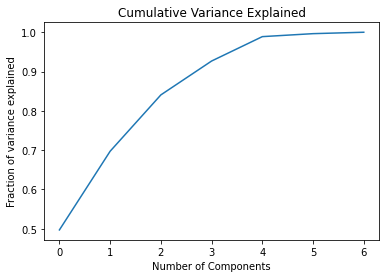

In [76]:
# 1st component explains 49.7% of the variation, 2nd component explains 20% of the variation, 3rd component explains 14.3% etcetc

plt.plot(cum_var_exp)
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Fraction of variance explained')
plt.show()

In [114]:
# try 4 components for modeling (91% cumulative variance explained)
comp = 3

Z_train_model = pd.DataFrame(Z_train_pca[:,:comp])
Z_test_model = pd.DataFrame(Z_test_pca[:,:comp])

# recombine the PCA components to the categorical features
Z_train = pd.concat([Z_train_model, Xb_train_cat], axis=1)
Z_test = pd.concat([Z_test_model, Xb_test_cat], axis=1)

In [78]:
evaluations_pca = []

for gs in pipe_gs:
    gs.fit(Z_train, yb_train)
    
    evaluations_pca.append({
        'pipe': [step[0] for step in gs.estimator.steps],
        'train score': gs.score(Z_train, yb_train),
        'cross val': cross_val_score(gs.estimator, Z_train, yb_train, cv=5).mean(),
        'test score': gs.score(Z_test, yb_test),
        'f1-score (train)': f1_score(y_true = yb_train, y_pred = gs.predict(Z_train)),
        'f1-score (test)': f1_score(y_true = yb_test, y_pred = gs.predict(Z_test))
    })
    
evaluations_pca_df = pd.DataFrame(evaluations_pca)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Done 193 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:    1.5s finished


Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 2680 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done 6680 tasks      | elapsed:   21.1s
[Parallel(n_jobs=4)]: Done 11980 tasks      | elapsed:   38.4s
[Parallel(n_jobs=4)]: Done 12000 out of 12000 | elapsed:   38.4s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    4.7s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    2.9s finished


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 1400 tasks      | elapsed:   13.4s
[Parallel(n_jobs=4)]: Done 1600 out of 1600 | elapsed:   15.3s finished


In [79]:
evaluations_pca_df

,pipe,train score,cross val,test score,f1-score (train),f1-score (test)
0,"[ss, lr]",0.723353,0.708982,0.717703,0.561670,0.528000
1,"[ss, knn]",0.744910,0.676647,0.732057,0.644407,0.626667
2,"[ss, cart]",0.701796,0.652695,0.703349,0.480167,0.465517
3,"[ss, bag]",0.895808,0.677844,0.746411,0.869955,0.682635
4,"[ss, rf]",0.724551,0.694611,0.712919,0.502165,0.473684
5,"[ss, ada]",0.782036,0.683832,0.703349,0.694631,0.569444
6,"[ss, svc]",0.744910,0.704192,0.732057,0.607735,0.569231


In [80]:
yb.value_counts(normalize=True)

0    0.606322
1    0.393678
Name: target, dtype: float64

The Bagging Classifier looks like it is now the best model, with K-Nearest Neighbor in close contention. It is still overfit, but with a test score 15% better than the baseline model and a test f1-score of 0.68.

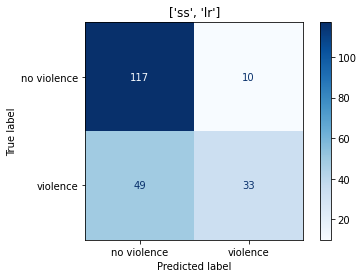

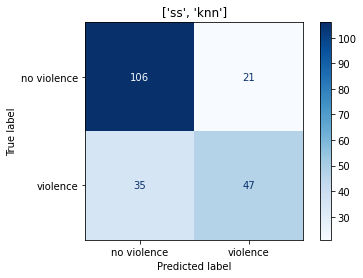

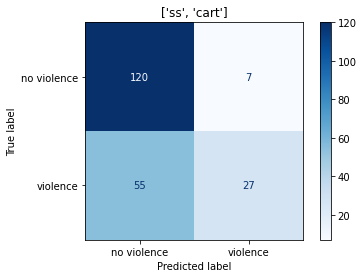

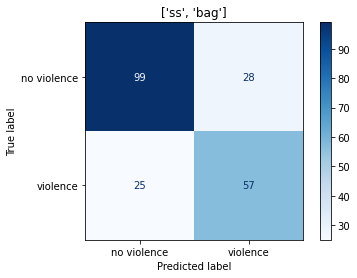

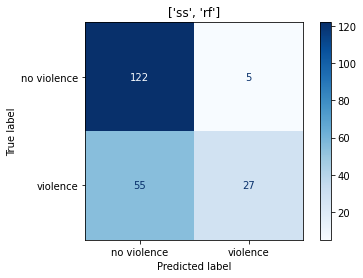

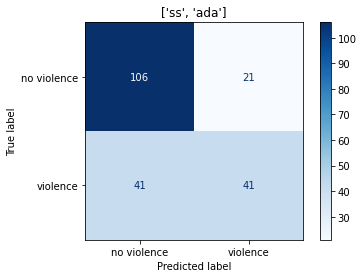

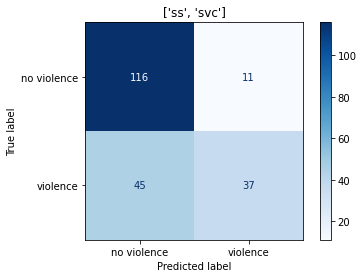

In [82]:
for gs in pipe_gs:
    plot_confusion_matrix(gs, Z_test, yb_test, cmap='Blues', 
                      values_format='d', display_labels=['no violence','violence']);
    plt.title([step[0] for step in gs.estimator.steps])

Let's see how these do when applied to the larger dataset.

### Apply PCA to larger dataset

In [84]:
# numerical X
Xxjune_num = Xxjune[num_cols].reset_index(drop=True)

# categorical X
Xxjune_cat = Xxjune.drop(columns=num_cols).reset_index(drop=True)

In [88]:
# Scale numerical X
Xxjune_num_sc = sc.transform(Xxjune_num)

# Apply PCA on numerical X
Zxjune_num_sc_pca = pca.transform(Xxjune_num_sc)

In [89]:
# try 4 components for modeling (91% cumulative variance explained)
Zxjune_model = pd.DataFrame(Zxjune_num_sc_pca[:,:comp])

# recombine the PCA components to the categorical features
Zxjune = pd.concat([Zxjune_model, Xxjune_cat], axis=1)

In [90]:
# Apply these models to the rest of the dataset (excluding all of June)

evaluations_pca_rest = []
for gs in pipe_gs:
    evaluations_pca_rest.append({
        'pipe': [step[0] for step in gs.estimator.steps],
        'test score': gs.score(Zxjune, yxjune),
        'f1-score (test)': f1_score(y_true = yxjune, y_pred = gs.predict(Zxjune))
    })
    
evaluations_pca_rest_df = pd.DataFrame(evaluations_pca_rest)

In [91]:
evaluations_pca_rest_df

,pipe,test score,f1-score (test)
0,"[ss, lr]",0.638346,0.309332
1,"[ss, knn]",0.629977,0.317693
2,"[ss, cart]",0.672415,0.301676
3,"[ss, bag]",0.616197,0.290181
4,"[ss, rf]",0.726689,0.296103
5,"[ss, ada]",0.679601,0.323456
6,"[ss, svc]",0.655677,0.317184


In [92]:
yxjune.value_counts(normalize=True)

0    0.866853
1    0.133147
Name: violence, dtype: float64

When applied to the rest of the dataset, the test scores are now lower than the baseline model. This still means that the models are not great for application to the larger dataset. Looks like these models work best on the dataset that we trained it on, and the most-alike dataset (events from the month of June).

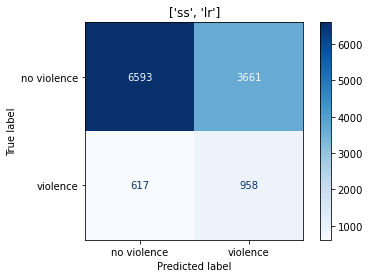

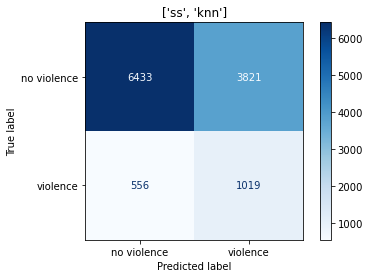

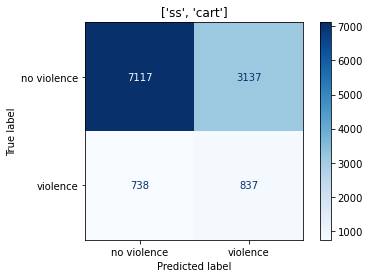

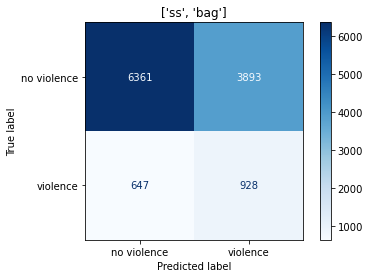

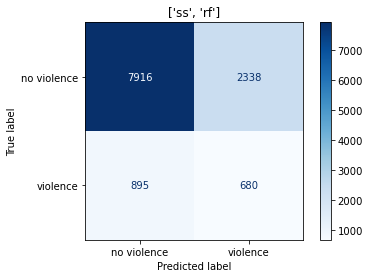

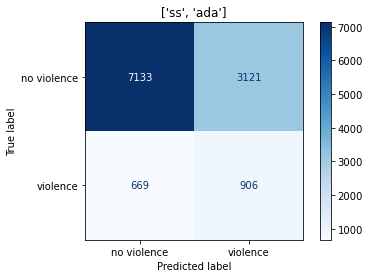

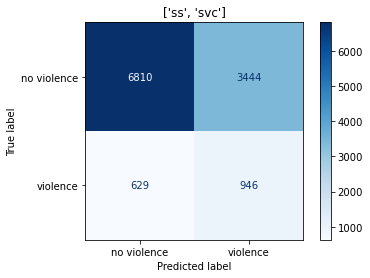

In [93]:
# plot confusion matrix
for gs in pipe_gs:
    plot_confusion_matrix(gs, Zxjune, yxjune, cmap='Blues', 
                      values_format='d', display_labels=['no violence','violence']);
    plt.title([step[0] for step in gs.estimator.steps])

## Try neural net

#### Set the TensorFlow random seed

In [95]:
tf.random.set_seed(42)

## Create and train a model

#### Create model structure

In [99]:
# Insert model here...
model = Sequential()

# First layer - input and 1st hidden layer
model.add(Dense(128, input_shape = (Z_train.shape[1], ),
               activation='relu'))

# Second hidden layer
model.add(Dense(64, activation='relu'))

# Third hidden layer
model.add(Dense(16, activation='relu'))

# output layer
model.add(Dense(1, activation='sigmoid')) # one neuron, sigmoid activation

#### Compile

In [100]:
model.compile(loss='bce', optimizer='adam', metrics=['acc'])

#### Make an EarlyStopping callback

In [101]:
early_stop = EarlyStopping(patience=5)

#### Fit the model

In [135]:
Z_train.rename(columns={0: 'PCA1', 1: 'PCA2', 2: 'PCA3'},inplace=True)
Z_test.rename(columns={0: 'PCA1', 1: 'PCA2', 2: 'PCA3'},inplace=True)

In [137]:
Zxjune.rename(columns={0: 'PCA1', 1: 'PCA2', 2: 'PCA3'},inplace=True)

In [138]:
# Solution for error: https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte
Z_train = np.asarray(Z_train).astype(np.float32)
Z_test = np.asarray(Z_test).astype(np.float32)
Zxjune = np.asarray(Zxjune).astype(np.float32)

In [122]:
results = model.fit(Z_train, yb_train, 
                         validation_data=(Z_test, yb_test),
                         epochs=100, batch_size=128,
                         verbose=0,
                         callbacks=[early_stop])

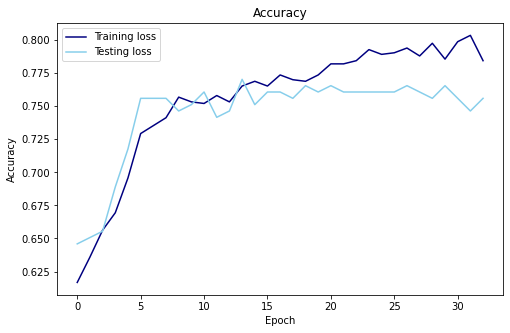

In [127]:
# Visualize loss
train_loss = results.history['acc']
test_loss = results.history['val_acc']

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

Slightly higher test accuracy compared to previous model.

In [129]:
preds = model.predict(Z_test).round()

In [131]:
pd.DataFrame(confusion_matrix(yb_test, preds),
            columns=['pred no-violence', 'pred violence'],
            index=['actual no-violence', 'actual violence']) # cast as a dataframe

,pred no-violence,pred violence
actual no-violence,105,22
actual violence,29,53


In [134]:
print(classification_report(yb_test, preds))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       127
           1       0.71      0.65      0.68        82

    accuracy                           0.76       209
   macro avg       0.75      0.74      0.74       209
weighted avg       0.75      0.76      0.75       209



Test accuracy of 0.76, test f1-score of 0.68. Not bad. Now let's apply to the rest of the dataset.

## Apply Neural Net to the rest of the dataset

In [139]:
results_rest = model.fit(Z_train, yb_train, 
                         validation_data=(Zxjune, yxjune),
                         epochs=100, batch_size=128,
                         verbose=0,
                         callbacks=[early_stop])

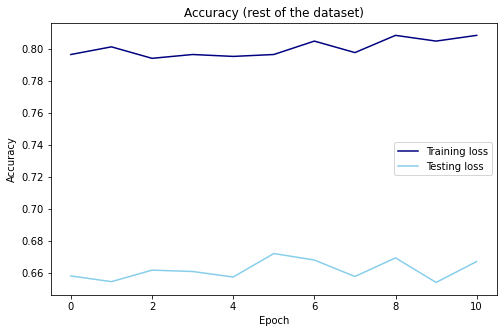

In [140]:
# Visualize loss
train_loss = results_rest.history['acc']
test_loss = results_rest.history['val_acc']

plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.title('Accuracy (rest of the dataset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [141]:
yxjune.value_counts(normalize=True)

0    0.866853
1    0.133147
Name: violence, dtype: float64

Still lower test accuracy compared to baseline model.

In [142]:
preds_rest = model.predict(Zxjune).round()

In [143]:
pd.DataFrame(confusion_matrix(yxjune, preds_rest),
            columns=['pred no-violence', 'pred violence'],
            index=['actual no-violence', 'actual violence']) # cast as a dataframe

,pred no-violence,pred violence
actual no-violence,6974,3280
actual violence,660,915


In [145]:
print(classification_report(yxjune, preds_rest))

              precision    recall  f1-score   support

           0       0.91      0.68      0.78     10254
           1       0.22      0.58      0.32      1575

    accuracy                           0.67     11829
   macro avg       0.57      0.63      0.55     11829
weighted avg       0.82      0.67      0.72     11829



We did notice when doing EDA that protests at the top 5 big cities had a higher occurrence of violence compared to the larger dataset. Perhaps we should cluster the data (unsupervised modeling) before performing supervised modeling.